# DLI 2019 Hackathon

**The theme** of the hackathon is wildlife conservation, and how AI, machine learning and data science can contribute. 

**The Dataset** will come from Zooniverse: https://www.zooniverse.org/projects/zooniverse/snapshot-serengeti.
Based on Snapshot Serengeti from https://snapshotserengeti.org

You can read more about [the data](https://www.nature.com/articles/sdata201526) and some initial research done under the "Snapshot Serengeti" project [here](https://arxiv.org/abs/1703.05830).

It is copyright and licensed under Creative Commons Attribution 4.0 International License. 
https://creativecommons.org/licenses/by/4.0/legalcode

The following modifications were made with permission from the authors:
  * Reduced the dataset to only feature the ten most populous species.
  * Prepared the data as TF Examples and saved in TF Records format to ease integration with TensorFlow.
  

**The dataset is split into:**

  * **Training set:**   236795 examples
  * **Validation set**:  13157 examples
  * **Test set:**        13154 examples

---  

**The following features are available for each datapoint:**

  * **Features**:
    * '**Images**': Between 1-3 JPEG encoded photographs of each event.
    * '**Embeddings**': A 128-dimensional feature representation of each image. Obtained from a [ResNet-50 (v1)](https://arxiv.org/abs/1512.03385) pretrained on ImageNet and fine-tuned on this data. This should make it easier for you to try some ML algorithms without working on raw image data.
    * '**SiteID**': The site id of the camera.
    * '**CaptureEventID**': A unique ID for the capture event.
    * '**LocationX**': Location of the camera (x)
    * '**LocationY**': Location of the camera (y)
    * '**DateTime**': The timestamp the of the capture event.
   


  * **Lables**:
    * '**NumSpecies**': Number of species identified.
    * '**Count**': The number of animals of each species identified.
    * '**Species**': The species present at the event.
  

**The following species are present**: 
  * buffalo
  * elephant
  * gazelleGrants
  * gazelleThomsons
  * giraffe
  * guineaFowl
  * hartebeest
  * impala
  * wildebeest
  * zebra


# First steps: Imports and data loading

In [0]:
#@title Imports (RUN ME!) { display-mode: "form" }

!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

from keras.models import load_model
import functools
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os
%matplotlib inline

print("TensorFlow executing eagerly: {}".format(tf.executing_eagerly()))

     |████████████████████████████████| 348.9MB 108kB/s 
     |████████████████████████████████| 3.1MB 48.6MB/s 
     |████████████████████████████████| 501kB 59.0MB/s 
TensorFlow executing eagerly: True


Using TensorFlow backend.


### First steps

1.   Go to the folder "Serengeti Hackathon" shared with you
2.   Right click the folder name and choose "Add to My Drive" from the drop-down menu

In [0]:
#@title Global variables [RUN ME!]

_TRAINING_SET_SIZE = 236795
_VALIDATION_SET_SIZE = 13157
_TEST_SET_SIZE = 13154

# All possible anmial species present in the dataset
_SPECIES = ['buffalo',
            'elephant',
            'gazelleGrants',
            'gazelleThomsons',
            'giraffe',
            'guineaFowl',
            'hartebeest',
            'impala',
            'wildebeest',
            'zebra',
            'none',  # No animals in the photograph
]

_SPECIES_TO_CLASS_ID = dict(zip(_SPECIES, range(len(_SPECIES))))

In [0]:
#@title Copy data from Google Cloud Storage to local disk

from google.colab import auth

auth.authenticate_user()

bucket_name = 'dli_indaba2019'
train_filename = 'training_set_with_embeddings128.tfrecord'
valid_filename = 'validation_set_with_embeddings128.tfrecord'
test_filename = 'test_set_with_embeddings128.tfrecord'
download_dir = '.'
!gsutil cp gs://{bucket_name}/{train_filename} {download_dir}
!gsutil cp gs://{bucket_name}/{valid_filename} {download_dir}
!gsutil cp gs://{bucket_name}/{test_filename} {download_dir}

Copying gs://dli_indaba2019/training_set_with_embeddings128.tfrecord...
- [1 files][ 15.8 GiB/ 15.8 GiB]   74.3 MiB/s                                   
Operation completed over 1 objects/15.8 GiB.                                     
Copying gs://dli_indaba2019/validation_set_with_embeddings128.tfrecord...
-
Operation completed over 1 objects/897.3 MiB.                                    
Copying gs://dli_indaba2019/test_set_with_embeddings128.tfrecord...
/ [1 files][901.7 MiB/901.7 MiB]                                                
Operation completed over 1 objects/901.7 MiB.                                    


In [0]:
#@title Load data
training_set_path = "training_set_with_embeddings128.tfrecord"
validation_set_path = "validation_set_with_embeddings128.tfrecord"
test_set_path =  "test_set_with_embeddings128.tfrecord"

# Create a `tf.data.Dataset` object from the recordio data
training_dataset = tf.data.TFRecordDataset(training_set_path)
validation_dataset = tf.data.TFRecordDataset(validation_set_path)
test_dataset = tf.data.TFRecordDataset(test_set_path)

# Shuffle data in the training set
training_dataset = training_dataset.shuffle(10000)
validation_dataset = validation_dataset
test_dataset = test_dataset

# Exploring the dataset

Now that we've set up the tensorflow objects, let's look at some of the training
datapoints to get a better feeling for the data we're dealing with.

For this, we'll first define some plotting functions:

In [0]:
#@title Adding some parsing & preprocessing utility functions

def show_single_record(example):
  """Show images, species and their count in one record."""
  
  # Decode all images associated with this record
  im_raws = example.features.feature['Images'].bytes_list.value
  im = [tf.image.decode_image(i) for i in im_raws]
  
  plt.figure(figsize=(10, 20))
  plt.imshow(np.hstack(im))
  labels = [example.features.feature[k].bytes_list.value 
            for k in ["Species","Count"]]
  
  species = [s.decode('utf-8') for s in labels[0]]
  counts = [l for l in labels[1]]
  plt.title(f'Species: {species},  Counts: {counts}, Image shape: {im[0].shape}')
  plt.axis('off')
  plt.show()
  
  return len(im)

def show_records(dataset, least_nb_labels=1, stop=5):
  """Show records with at least "least_nb_labels" labels and finish after 'stop' cases."""
  example = tf.train.Example()
  nb_cases = 0
  for raw_record in dataset:
    example.ParseFromString(raw_record.numpy())
    species = example.features.feature['Species'].bytes_list.value
    if len(species) >= least_nb_labels:
      nb_cases += 1
      show_single_record(example)
      if nb_cases == stop: 
        return
          


And then look at some of photographs. What do you notice?

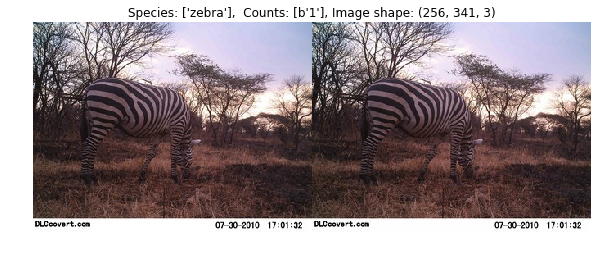

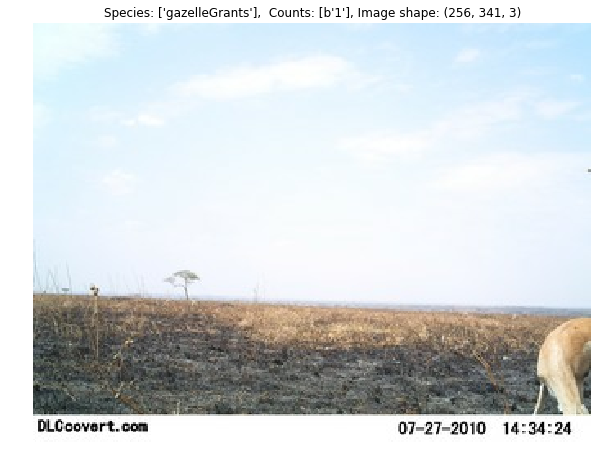

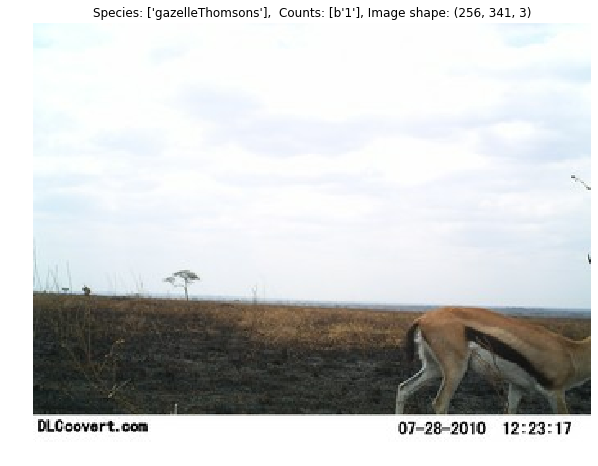

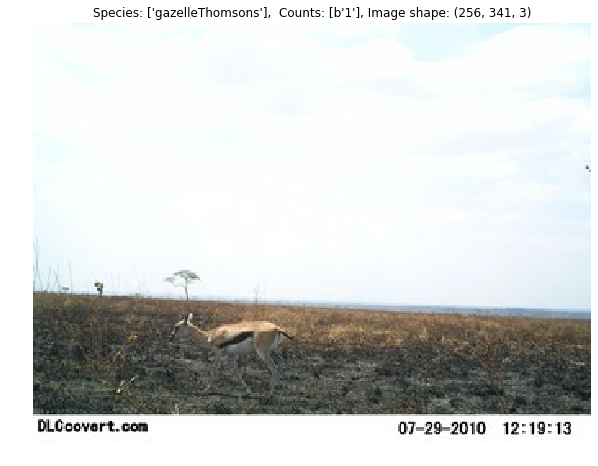

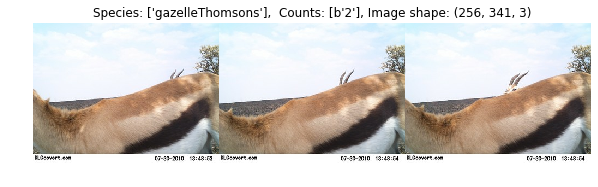

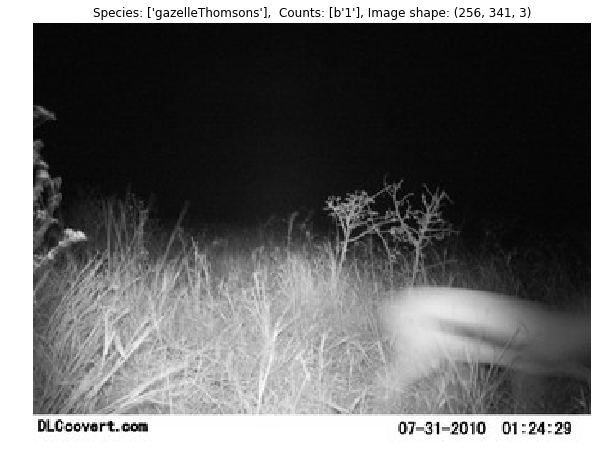

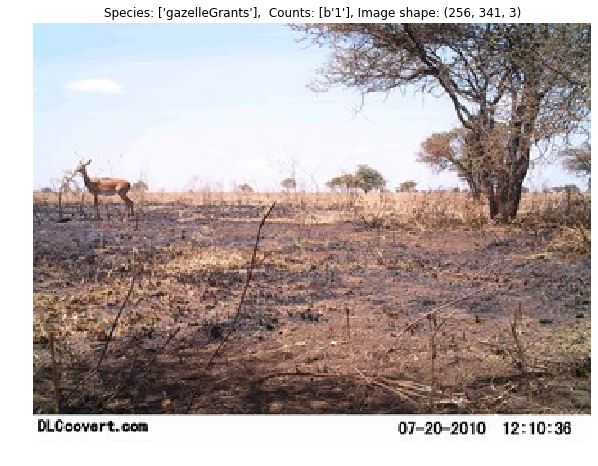

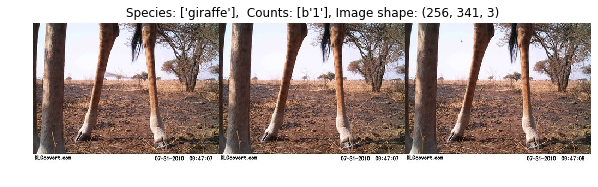

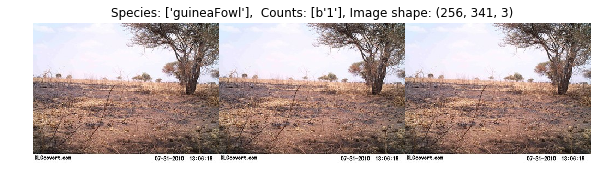

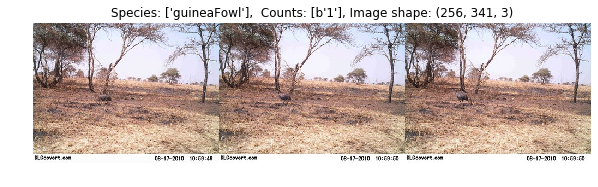

In [0]:
#@title Plot some images

how_many = 10 #@param

show_records(test_dataset, stop=how_many)

Some observations:

* It turns out not all records have a constant number of images, some have 1, 2 or even 3.
* Sometimes images are take at unsual angles, at night, in grayscale or under vastly different lighting conditions.
* Animals appear in varying distances to the camera.
* We can have multiple animals in a single photograph.
* Fortunately, all images have the same size: 256 x 341 and always have 3 colour channels.
* **What else did you notice?**





The function `show_record_with_many_labels` has a `least_nb_labels` argument. What happens if we set this to a value higher than 1?


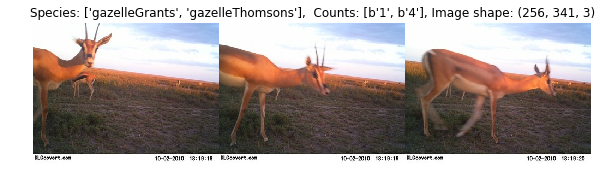

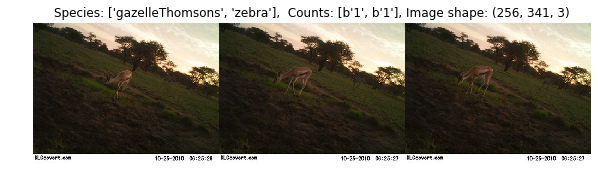

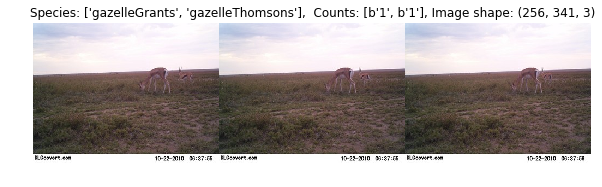

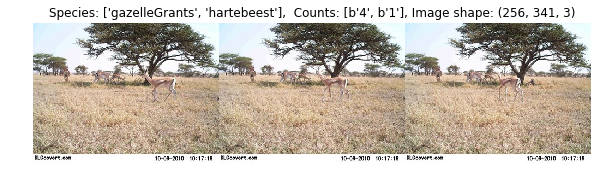

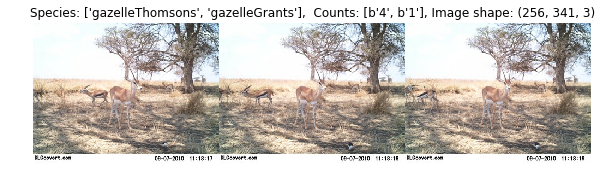

In [0]:
#@title Plot images with `least_nb_labels` = 2

how_many = 5 #@param

show_records(
    training_dataset, least_nb_labels=2, stop=how_many)

Turns out some of photographs not only have **multiple animals** but also **multiple species** in them!

This gives rise to some interesting questions:
* Machine Learning: How do we deal with this when building a supervised machine   learning model?
* Ecology: Which species co-exist with each other?
* These are only a small number of examples of the fascinating questions this datasets
  allows us to answer.

# Training a first model

In this section we will build, train & evaluate two simple image recognition models:

*   **Using sklearn**: A logistic regression classifier on the ResNet embeddings.
*   **Using Tensorflow**: A convolutional Neural Network (CNN) on raw image data.

For now, we'll make some simplifying assumptions:

* We will only deal with image classification and thus ignore the `count` label.
* If multiple photographs are present in a single entry, we will only use the first one.
* Similarly, if multiple species labels are available, we only select the first label in the list.
* For the CNN model, we downscale images to a size of [150, 150], using tensorflow's `tf.image.resize`

During this week, you should rethink the process of association between an image and its labels.



#### Helper functions for reading the TFRecord files

So now, we know how to read and display an image from tfrecord files using TFRecorder 2.0.


Let's define some functions to get the data and associated labels for training.

Needed features:


1.   Data: "**Images**" & "**Embeddings**"
2.   Labels: "**Count**" and "**Species**"

In [0]:
#@title Adding some parsing & preprocessing utility functions

feature_description = { 
    'Images': tf.compat.v1.FixedLenSequenceFeature(
        [], tf.string, allow_missing=True),
    'Embeddings': tf.compat.v1.FixedLenSequenceFeature(
        [], tf.string, allow_missing=True),
    'SiteID': tf.compat.v1.FixedLenFeature([], tf.string, default_value=''),
    'CaptureEventID': tf.compat.v1.FixedLenFeature(
        [], tf.string, default_value=''),
    'LocationX': tf.compat.v1.FixedLenFeature([], tf.int64, default_value=0),
    'LocationY': tf.compat.v1.FixedLenFeature([], tf.int64, default_value=0),
    'DateTime': tf.compat.v1.FixedLenFeature([], tf.string, default_value=''),
    # Labels
    'NumSpecies': tf.compat.v1.FixedLenFeature([], tf.int64, default_value=0),
    'Count': tf.compat.v1.VarLenFeature(tf.string),
    'Species': tf.compat.v1.VarLenFeature(tf.string),
}

def deserialize_embeddings(serialized_embeddings):
  """Deserialize embeddings and set shape."""
  parse_float32_tensor = functools.partial(
      tf.io.parse_tensor, out_type=tf.float32)
  embeddings = tf.map_fn(
      parse_float32_tensor, serialized_embeddings, dtype=tf.float32) 
  # `None` indicates a dimension of varying size, 128 is the size of the feature vector
  embeddings.set_shape([None, 1, 128])

  return embeddings[:, 0, :]

def parse_function(example_proto):
  """Parse the input tf.Example proto using the dictionary above."""
  
  parsed_example = tf.compat.v1.parse_single_example(
      example_proto, feature_description)
  
  # Decode jpeg encoded image data
  parsed_example["Images"] = tf.map_fn(
      tf.image.decode_jpeg, parsed_example["Images"], dtype=tf.uint8) 
  
  # Deserialize embeddings
  parsed_example["Embeddings"] = deserialize_embeddings(
      parsed_example["Embeddings"])
  
  # Convert sparse string tensor to dense
  parsed_example["Species"] = tf.compat.v1.sparse_tensor_to_dense(
      parsed_example["Species"], default_value="none", name="Species")
  parsed_example["Count"] = tf.compat.v1.sparse_tensor_to_dense(
      parsed_example["Count"], default_value='0', name='Count')
  
  return parsed_example


def image_preprocessing(image, downsized_image_size):
  """Some basic image preprocessing."""
  image = tf.cast(image, tf.float32)

  # Re-scale features to be in [0, 1]
  image = (image / 255.0) 
  image = tf.image.resize(
      image, (downsized_image_size, downsized_image_size))
  
  return image


def format_data(example, downsized_image_size=150):
  """Access a subset of available features and labels."""
  
  # Only deal with the first image, embedding & label
  image = image_preprocessing(example['Images'][0], downsized_image_size)
  label = example['Species'][0]
  embedding = example['Embeddings'][0]
  
  return image, embedding, label

## Trying a linear model on the ResNet embeddings (with sklearn)

When facing a new machine learning problem, it is often useful to try a simple algorithm first. Since we've been provided with ResNet features, we could simply try a linear classifier on those features. 

Note that sklearn's `fit` method expects numpy arrays. In order to provide this, we will convert from tensorflow tensors to numpy arrays using the function `load_data_as_np_arrays`. **WARNING:** All the data returned from this function will be kept in RAM. Be aware of this when attempting to use the entire training data.

In [0]:
#@title Convert data to numpy arrays

def load_data_as_np_arrays(dataset, return_images=False):
  """Load data as numpy arrays. Optionally return raw image data"""
  images = [] if return_images else None
  embeddings = []
  labels = []
  
  for i, e, l in dataset:
    if return_images:
      images.append(i.numpy())
    embeddings.append(e.numpy())
    labels.append(_SPECIES_TO_CLASS_ID[l.numpy().decode('utf-8')])
  
  # Convert to numpy array
  if return_images:
    images = np.array(images)
  embeddings = np.array(embeddings)
  labels = np.array(labels)
  
  return images, embeddings, labels

n_train_images_to_use =  -1#@param

train_set = training_dataset.map(parse_function).map(format_data).take(n_train_images_to_use)
# Use the entire validation and test set
valid_set = validation_dataset.map(parse_function).map(format_data)
test_set = test_dataset.map(parse_function).map(format_data)

# Load data as numpy arrays
_, train_embeddings, train_labels = load_data_as_np_arrays(train_set)
_, valid_embeddings, valid_labels = load_data_as_np_arrays(valid_set)
test_images, test_embeddings, test_labels = load_data_as_np_arrays(test_set, return_images=True)

In [0]:
#@title Training Logistic Regression

from sklearn.linear_model import LogisticRegression

max_training_iterations = 5000 #@param


# Set up a LogisticRegression object
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial', 
                         max_iter=max_training_iterations)
# Train on training data
clf.fit(train_embeddings, train_labels)

valid_predictions = clf.predict(valid_embeddings)
valid_acc = (valid_predictions == valid_labels).mean()

print("Your validation accuracy is: {:.2f}%".format(100 * valid_acc))

Your validation accuracy is: 60.39%


### Evaluating the model

We now use our trained model to classify a sample of 25 images from the test set. We pass these 25 images to the  ```model.predict``` function, which returns a [25, 10] dimensional matrix. The entry at position $(i, j)$ of this matrix contains the probability that image $i$ belongs to class $j$. We obtain the most-likely prediction using the ```np.argmax``` function which returns the index of the maximum entry along the columns. Finally, we plot the result with the prediction and prediction probability labelled underneath the image and true label on the side. 

In [0]:
#@title Test set results

test_predictions = clf.predict(test_embeddings)
test_acc = (test_predictions == test_labels).mean()

print("Your test accuracy is: {:.2f}%".format(100 * test_acc))

Your test accuracy is: 60.50%


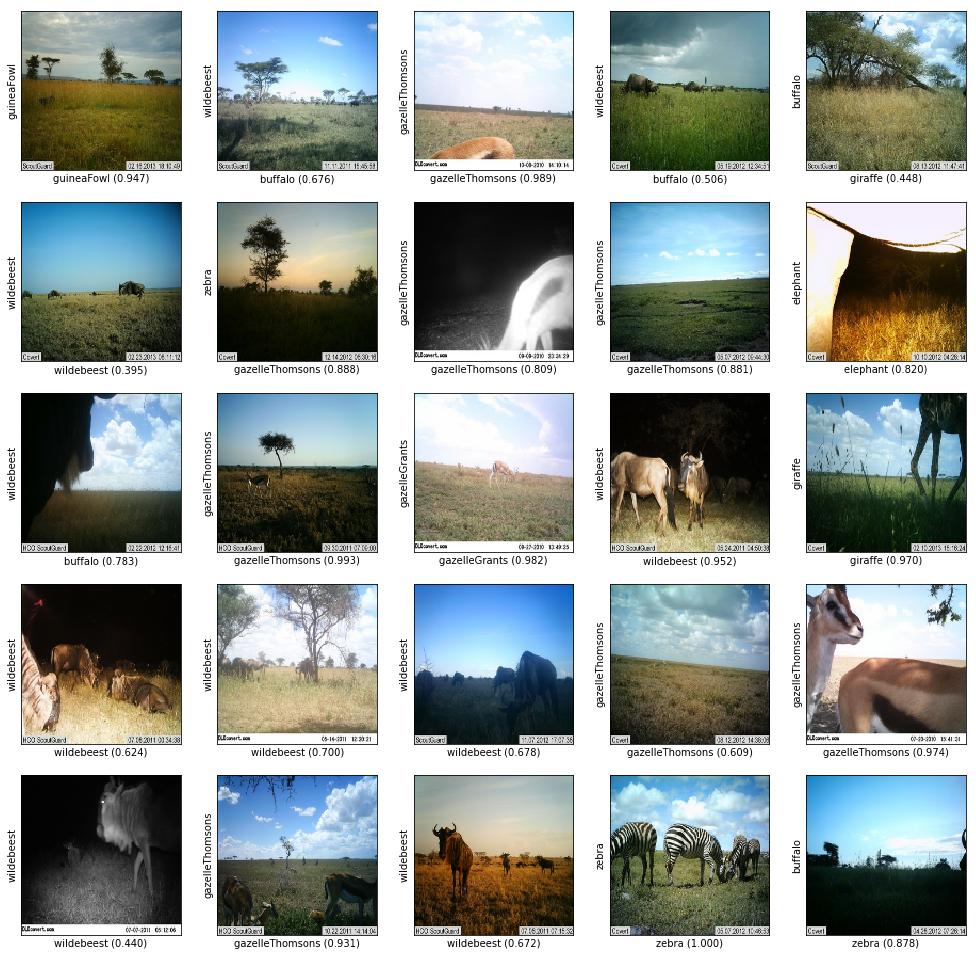

In [0]:
#@title Example test set classifications

n_test_examples = 25 #@param 

img_indices = np.random.randint(0, len(test_images), size=[n_test_examples])
sample_test_images = test_images[img_indices]
sample_test_embeddings = test_embeddings[img_indices]
sample_test_labels = [_SPECIES[i] for i in test_labels[img_indices].squeeze()]

predictions = clf.predict_proba(sample_test_embeddings)
max_prediction = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

plt.figure(figsize=(17,17))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(_SPECIES[prediction], prob))
  plt.ylabel('{}'.format(true_label))

## Training first convolutional neural network (CNN)

For those of you keen on putting your Deep Learning skills into practice, we will now train a first CNN on raw image data. Because we can do everything in tensorflow, we won't need to manually convert everything to numpy first. This also means we can easily use the entire training dataset.



In [0]:
#@title Setting up the model. From the CNN practical here: https://colab.research.google.com/drive/1GhO1DN8J1lmgIgV1zuKKMWd6m0SCUC5m

# Model parameters
n_filters_1 = 48 #@param
n_filters_2 = 128 #@param
n_filters_3 = 192 #@param
n_filters_4 = 192 #@param
n_filters_5 = 128 #@param
n_units_dense_1 = 1024 #@param


conv2d_3x3_selu = functools.partial(tf.keras.layers.Conv2D,
                                    kernel_size=(3,3),
                                    activation=tf.nn.selu,
                                    padding='same')


cnn_model = tf.keras.models.Sequential([
    conv2d_3x3_selu(filters=n_filters_1),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    conv2d_3x3_selu(filters=n_filters_2),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
    tf.keras.layers.BatchNormalization(),
    conv2d_3x3_selu(filters=n_filters_3),
    conv2d_3x3_selu(filters=n_filters_4),
    conv2d_3x3_selu(filters=n_filters_5),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(n_units_dense_1, activation=tf.nn.selu),
    tf.keras.layers.Dense(len(_SPECIES)),
])

In [0]:
#@title Setting up data, losses, optimizer and the training step
  
learning_rate = 1e-4 #@param
batch_size = 32 #@param
n_training_examples_to_use = -1 #@param

# Set up a loss and an optimizer
loss_fn = tf.nn.sparse_softmax_cross_entropy_with_logits
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Metrics 
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
eval_loss = tf.keras.metrics.Mean(name='eval_loss')
eval_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='eval_accuracy')

# Prepare training and validation datasets
training_dataset_cnn = training_dataset.map(parse_function).map(format_data).take(n_training_examples_to_use).batch(batch_size)
validation_dataset_cnn = validation_dataset.map(parse_function).map(format_data).batch(256)

In [0]:
load_model("model.h5")

In [0]:
cnn_model.get_weights()

ValueError: ignored

In [0]:
num_epochs = 2 #@param
report_every = 25 #@param


def _labels_to_ids(labels):
  return [_SPECIES_TO_CLASS_ID[l.decode('utf-8')] 
          for l in labels.numpy()]


def _evaluate_model(model, dataset):
  # Evaluation loop
  eval_acc = []
  all_eval_predictions = []
  n_examples = 0
  for eval_images, _, eval_labels in dataset:
    eval_labels = _labels_to_ids(eval_labels)
    eval_predictions = tf.argmax(model(eval_images), axis=1)
    all_eval_predictions.extend(eval_predictions.numpy().tolist())
    n_examples += len(eval_labels)
    eval_acc.append((eval_predictions.numpy() == eval_labels).sum())

  return np.sum(eval_acc) / n_examples, np.array(all_eval_predictions)
  

for epoch in range(num_epochs):
  # Training loop
  idx = 0
  for images, _, labels in training_dataset_cnn:
    labels = _labels_to_ids(labels)
    
    with tf.GradientTape() as tape:
      logits = cnn_model(images)
      loss = tf.reduce_mean(loss_fn(labels=labels, logits=logits))
      
    predictions = tf.argmax(logits, axis=1)
    
    # Backpropagation
    gradients = tape.gradient(loss, cnn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, cnn_model.trainable_variables))      
     
    if 0 == (idx % report_every):
      training_acc = (predictions.numpy() == labels).mean()
      print('Step {}: Training loss: {:.4f} Training accuracy: {:.2f}'.format(
            idx, loss.numpy(), training_acc))
    idx += 1
    
  valid_acc = _evaluate_model(cnn_model, validation_dataset_cnn)
  print("Your validation accuracy is: {:.2f}%".format(100 * valid_acc))

Step 0: Training loss: 0.0152 Training accuracy: 1.00
Step 25: Training loss: 0.1504 Training accuracy: 0.97


KeyboardInterrupt: ignored

### Evaluating the model

In [0]:
#@title Load test data

test_dataset_cnn = test_dataset.map(parse_function).map(format_data).batch(256)
test_acc, test_predictions = _evaluate_model(cnn_model, test_dataset_cnn)
print("Your test accuracy is: {:.2f}%".format(100 * test_acc))

Your test accuracy is: 73.68%


In [0]:
test_predictions

array([9, 3, 3, ..., 8, 8, 8])

In [0]:
def _get_predictions(model, dataset):
  # Training loop
  idx = 0
  for images, _, labels in test_dataset_cnn:
    labels = _labels_to_ids(labels)
    
    with tf.GradientTape() as tape:
      logits = cnn_model(images)
      loss = tf.reduce_mean(loss_fn(labels=labels, logits=logits))
      
    predictions = tf.argmax(logits, axis=1)
    
    # Backpropagation
    gradients = tape.gradient(loss, cnn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, cnn_model.trainable_variables))      
     
    if 0 == (idx % report_every):
      training_acc = (predictions.numpy() == labels).mean()
      print('Step {}: Training loss: {:.4f} Training accuracy: {:.2f}'.format(
            idx, loss.numpy(), training_acc))
    idx += 1
    
  valid_acc = _evaluate_model(cnn_model, validation_dataset_cnn)
  print("Your validation accuracy is: {:.2f}%".format(100 * valid_acc))
  


In [0]:
eval = _get_predictions(cnn_model, test_dataset_cnn)

In [0]:
len(eval)

2

In [0]:
# test_dataset_cnn = test_dataset.map(parse_function).map(format_data).batch(256)
# test_predictions = _get_predictions(cnn_model,test_dataset_cnn)

test_dataset_cnn = test_dataset.map(parse_function).map(format_data).take(-1).batch(batch_size)

In [0]:
for eval_images, _, eval_labels in test_dataset_cnn:
    eval_labels = _labels_to_ids(eval_labels)
    eval_predictions = tf.argmax(model(eval_images), axis=1)
    
    n_examples += len(eval_labels)
    eval_acc.append((eval_predictions.numpy() == eval_labels).sum())



tensorflow.python.data.ops.dataset_ops.BatchDataset

In [0]:
# test_images.shape
prediction=[]
for images in test_images:
    
    logits = cnn_model(images)    
    predictions.append(tf.argmax(logits, axis=1))


InvalidArgumentError: ignored

In [0]:
test_predictions.numpy().shape

AttributeError: ignored

In [0]:
def _mean_per_class_accuracy(test_predictions):
  """Return the mean per species accuracy.
  This will evaluate the accuracy for each species separately and then take the
  average of those metrics.
  Args:
    test_predictions: A `np.array` of type float. Predictions on the full test set.
  """
  test_labels_filename = 'test_labels.npy'
  if not os.path.exists(test_labels_filename):
    # Download test labels if not present
    download_dir = '.'
    !gsutil cp gs://{bucket_name}/{test_labels_filename} {download_dir}
  
  # Load data into local variable
  with open(test_labels_filename, 'rb') as f:
    test_labels = np.load(f)
    
  print(test_labels.size)  
  assert test_labels.size == test_predictions.size, 'Invalid input!'
  per_class_accuracies = [] 
  for class_id in range(len(_SPECIES)-1):
    # Get predictions for images that actually contain animals of `class_id`
    test_set_idx = np.where(test_labels == class_id)
    # Check how many times our prediction matched the correct label
    per_class_accuracy = np.mean(test_predictions[test_set_idx[0]] == class_id)
    per_class_accuracies.append(per_class_accuracy)
  
  return np.mean(per_class_accuracies)

In [0]:
_mean_per_class_accuracy(test_predictions)

13154


0.6461102303376821